In [2]:
import pybaseball as pb
import pandas as pd

In [3]:
# Function to calculate pitch usage by count and batter handedness
def get_usage(df: pd.DataFrame, by_hand = True) -> dict:
    if by_hand == True:
        usage_dict = {}

        # Create Count columns
        df['Count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str)

        # Calculate pitch usage by count and batter handedness
        usage = df.groupby(['Count', 'pitch_type', 'stand'])['pitch_type'].count().reset_index(name = 'Usage')

        # Reshape the DataFrame to have pitch types and batter handedness as columns
        usage = usage.pivot(index = 'Count', columns = ['pitch_type', 'stand'], values = 'Usage').fillna(0).astype(object).reset_index()

        # Reformat column names for easier access
        usage.columns = [
            f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col
            for col in usage.columns
        ]
        usage.rename(columns = {'Count_' : 'Count'}, inplace = True)

        # Calculate pitch usage percentages by handedness
        for index, row in usage.iterrows():
            # Split by L and R
            l_total = 0
            r_total = 0

            # Calculate totals for L and R
            for col in usage.columns[1:]:
                if col.endswith('_L'):
                    l_total += row[col]
            for col in usage.columns[1:]:
                if col.endswith('_R'):
                    r_total += row[col]

            # Calculate percentages
            for pt in usage.columns[1:]:
                if pt.endswith('_L'):
                    total = l_total
                else:
                    total = r_total
                usage.loc[index, pt] = f"{usage.loc[index, pt] / total:.1%}"

        # Create separate DataFrames for lefty and righty usage
        lefty_usage = usage[['Count'] + [col for col in usage.columns if col.endswith('_L')]]
        righty_usage = usage[['Count'] + [col for col in usage.columns if col.endswith('_R')]]

        # Clean up column names
        lefty_usage.columns = [col.replace('_L', '') for col in lefty_usage.columns]
        righty_usage.columns = [col.replace('_R', '') for col in righty_usage.columns]

        # Append to usage dictionary
        usage_dict['L'] = lefty_usage
        usage_dict['R'] = righty_usage

        # Return the dictionary containing lefty and righty usage DataFrames
        return usage_dict
    else:
        usage_dict = {}

        # Create Count columns
        df['Count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str)

        # Calculate pitch usage by count
        usage = df.groupby(['Count', 'pitch_type'])['pitch_type'].count().reset_index(name = 'Usage')

        # Reshape the DataFrame to have pitch types as column
        usage = usage.pivot(index = 'Count', columns = ['pitch_type'], values = 'Usage').fillna(0).astype(object).reset_index()


        # Calculate pitch usage percentages by handedness
        for index, row in usage.iterrows():
            total = 0
            # Calculate total by row
            for col in usage.columns[1:]:
                total += row[col]

            # Calculate percentages
            for pt in usage.columns[1:]:
                usage.loc[index, pt] = f"{usage.loc[index, pt] / total:.1%}"

        usage_dict['all'] = usage.reset_index()

        # Return the list containing the single dataframe
        return usage_dict

In [4]:
data = pd.read_parquet('data/statcast_data_2025.parquet')

first_name = input("Enter player's first name: ")
last_name = input("Enter player's last name: ")
player_id = pb.playerid_lookup(last_name, first_name)

by_hand = True

try:
    player_stats = data[data['pitcher'] == player_id['key_mlbam'][0]].copy()
    player_usage = get_usage(player_stats, by_hand = by_hand)
    if by_hand == False:
        player_usage = player_usage['all']
        print(f"Pitch Usage for {first_name} {last_name}:")
        display(player_usage)
    else:
        player_lefty_usage = player_usage['L']
        player_righty_usage = player_usage['R']
        print(f"Pitch Usage for {first_name} {last_name}:")
        print("Pitch Usage Against Left-handed hitters:")
        display(player_lefty_usage)
        print("Pitch Usage Against Right-handed hitters:")
        display(player_righty_usage)
except Exception as e:
    print(f"Error retrieving data for {first_name} {last_name}: {e}")
    exit()

Gathering player lookup table. This may take a moment.
Pitch Usage for Payton Tolle:
Pitch Usage Against Left-handed hitters:


,Count,FC,FF,SL,CU
0,0-0,31.2%,62.5%,6.2%,0.0%
1,0-1,25.0%,62.5%,0.0%,12.5%
2,0-2,40.0%,40.0%,20.0%,0.0%
3,1-0,16.7%,83.3%,0.0%,0.0%
4,1-1,28.6%,57.1%,14.3%,0.0%
5,1-2,12.5%,62.5%,12.5%,12.5%
6,2-0,0.0%,100.0%,0.0%,0.0%
7,2-1,0.0%,100.0%,0.0%,0.0%
8,2-2,25.0%,62.5%,12.5%,0.0%
9,3-0,0.0%,100.0%,0.0%,0.0%


Pitch Usage Against Right-handed hitters:


,Count,FC,FF,SI,SL,CH,CU
0,0-0,23.7%,72.9%,1.7%,1.7%,0.0%,0.0%
1,0-1,12.1%,60.6%,0.0%,3.0%,18.2%,6.1%
2,0-2,0.0%,61.1%,0.0%,0.0%,5.6%,33.3%
3,1-0,39.1%,56.5%,0.0%,4.3%,0.0%,0.0%
4,1-1,8.7%,73.9%,0.0%,0.0%,17.4%,0.0%
5,1-2,4.0%,60.0%,0.0%,4.0%,16.0%,16.0%
6,2-0,70.0%,30.0%,0.0%,0.0%,0.0%,0.0%
7,2-1,45.5%,27.3%,0.0%,0.0%,9.1%,18.2%
8,2-2,8.7%,60.9%,0.0%,4.3%,17.4%,8.7%
9,3-0,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%


In [5]:
import pandas as pd
from great_tables import GT

def plot_usage(usage: pd.DataFrame) -> dict:

    df = usage.copy()

    # Convert percentage strings to numeric
    for col in df.columns[1:]:
        if df[col].dtype == 'object':
            df[col] = df[col].str.rstrip('%').astype(float)
        else:
            df[col] = df[col].astype(float)

    # Split Count into Balls and Strikes
    df[['Balls', 'Strikes']] = df.iloc[:, 0].astype(str).str.split('-', expand=True).astype(int)

    # All columns except Count, Balls, Strikes
    pitch_types = df.columns[1:-2]

    gt_tables = {}

    for pitch in pitch_types:
        # Pivot table: Rows = Balls, Columns = Strikes
        pivot = df.pivot(index='Balls', columns='Strikes', values=pitch)
        
        # Convert columns to strings for GT
        pivot.columns = pivot.columns.astype(str)
        pivot.columns.name = None
        
        # Format for display as strings with %
        pivot_display = pivot.apply(lambda col: col.map(lambda x: f"{x:.1f}%")).reset_index()
        
        # Rename the index column to empty string
        pivot_display.rename(columns={'Balls': ''}, inplace=True)
        
        # Create GT table
        gt_table = (
            GT(pivot_display)
            .tab_header(title=f"{pitch} Usage by Count")
            .data_color(
                columns=list(pivot_display.columns[1:]),  # color only numeric columns
                palette=["lightblue", "darkgreen"]
            )
        )
        
        gt_tables[pitch] = gt_table

    return gt_tables


In [11]:
test = plot_usage(player_usage['R'])
# Get key names
test.keys()
test['FF']

GT(_tbl_data=           0      1       2
0  0   72.9%  60.6%   61.1%
1  1   56.5%  73.9%   60.0%
2  2   30.0%  27.3%   60.9%
3  3  100.0%  87.5%  100.0%, _body=<great_tables._gt_data.Body object at 0x777ed6be9840>, _boxhead=Boxhead([ColInfo(var='', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='right', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='0', column_align='right', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='1', column_align='right', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='2', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x777ed62f5600>, _spanners=Spanners([]), _heading=Heading(title='FF Usage by Count', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='0', rows=[0], mask=None), grpname=None, colname='0', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#add8e6')]), StyleInfo(locname=LocBody(columns='0', rows=[1], mask=None), grpname=None, colname='0', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#73b199')]), StyleInfo(locname=LocBody(columns='0', rows=[2], mask=None), grpname=None, colname='0', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#3a8b4d')]), StyleInfo(locname=LocBody(columns='0', rows=[3], mask=None), grpname=None, colname='0', rownum=3, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#006400')]), StyleInfo(locname=LocBody(columns='1', rows=[0], mask=None), grpname=None, colname='1', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#add8e6')]), StyleInfo(locname=LocBody(columns='1', rows=[1], mask=None), grpname=None, colname='1', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#73b199')]), StyleInfo(locname=LocBody(columns='1', rows=[2], mask=None), grpname=None, colname='1', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#3a8b4d')]), StyleInfo(locname=LocBody(columns='1', rows=[3], mask=None), grpname=None, colname='1', rownum=3, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#006400')]), StyleInfo(locname=LocBody(columns='2', rows=[0], mask=None), grpname=None, colname='2', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#add8e6')]), StyleInfo(locname=LocBody(columns='2', rows=[1], mask=None), grpname=None, colname='2', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=Non

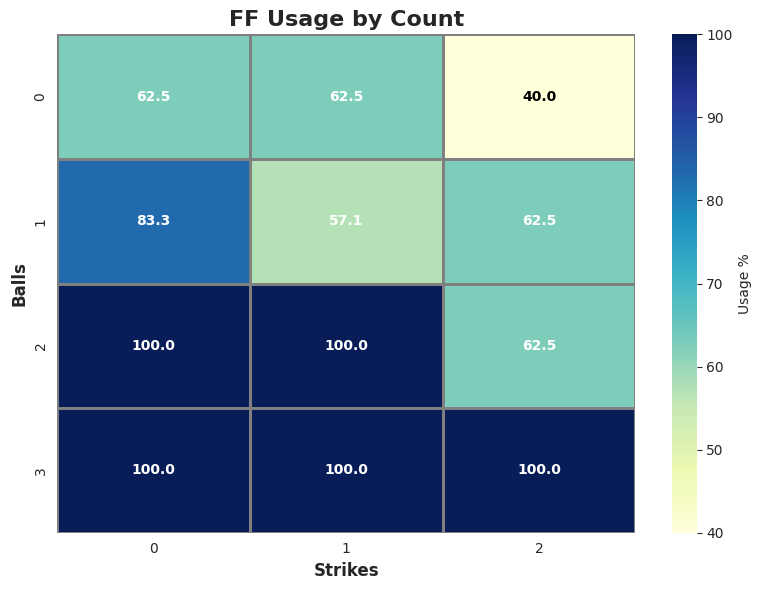

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copy your DataFrame
df = player_lefty_usage.copy()

# Convert percentages to numeric
for col in df.columns[1:]:
    df[col] = df[col].str.rstrip('%').astype(float)

# Split Count into Balls and Strikes
df[['Balls', 'Strikes']] = df['Count'].str.split('-', expand=True).astype(int)

# Pick a pitch (example: Fastball 'FF')
pitch = 'FF'

# Pivot to Balls x Strikes
pivot = df.pivot(index='Balls', columns='Strikes', values=pitch)

# Sort index and columns just in case
pivot = pivot.sort_index().sort_index(axis=1)

# Set up Seaborn style
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))

# Create heatmap
ax = sns.heatmap(
    pivot,
    annot=True,             # show values in cells
    fmt=".1f",              # format values
    cmap="YlGnBu",          # professional blue-green palette
    cbar_kws={'label': 'Usage %'}, # colorbar label
    linewidths=0.8,         # cell borders
    linecolor='gray'
)

# Style axes
ax.set_xlabel("Strikes", fontsize=12, weight='bold')
ax.set_ylabel("Balls", fontsize=12, weight='bold')
ax.set_title(f"{pitch} Usage by Count", fontsize=16, weight='bold')

# Optional: make annotations bold and white if dark
for t in ax.texts:
    t.set_weight('bold')
    # Optional: change text color based on value
    t.set_color("white" if float(t.get_text()) > 50 else "black")

plt.tight_layout()
plt.show()


In [ ]:
velos = hb_stats.groupby('pitch_type')['release_speed'].mean().reset_index().sort_values(by = 'release_speed', ascending = False)
velos

NameError: name 'hb_stats' is not defined